## Procesamiento de Lenguaje Natural
## Práctica 4: DOR (Este notebook esta COMPLETO por lo que no tienes que subirlo)

### Lectura simple de datos

In [1]:
import os
import re
from keras.preprocessing.text import Tokenizer
def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []
    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for twitt in f_corpus:
            tr_txt += [twitt]
        for label in f_truth:
            tr_y += [label]        
    return tr_txt, tr_y



Using TensorFlow backend.


In [2]:
tr_txt, tr_y = get_texts_from_file("./mex_train.txt", "./mex_train_labels.txt")

### Estadisticas Simples

In [3]:
tr_y = list(map(int, tr_y))

Counter({0: 3563, 1: 1981})


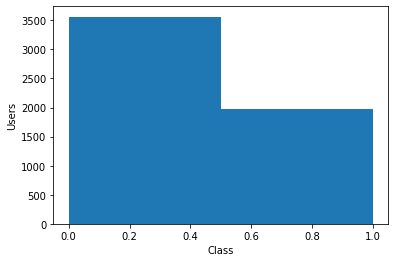

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(tr_y))
plt.hist(tr_y, bins=len(set(tr_y)))
plt.ylabel('Users');
plt.xlabel('Class');

# Un ojo a los datos

In [5]:
tr_txt[:10]

['lo peor de todo es que no me dan por un tiempo y luego vuelven estoy hasta la verga de estl\n',
 'a la vga no seas mamón 45 putos minutos después me dices que apenas sales no me querías avisar en 3 horas? 😑\n',
 'considero que lo más conveniente seria que lo retes a unos vergazos mi jelipe! rómpele la madre a ese pinchi joto!\n',
 'el marica de mi ex me tiene bloqueada de todo así  uno no puede admirar la "belleza" de su garnacha 😂\n',
 'mujer despechadaya pinche amlo hazle esta que se pela la loca #reynosafollow #reynosa\n',
 'putos. no tienen madre. ambriados mantenidos. ojetes. como es posible. mejor matarlos\n',
 'ustedes si puden andar de chanceros pero cuidadito y seamos nosotras porque luego luego empiezan a mamar hijos de la chingada.\n',
 '@usuario jajjaja te digo esa madre si está buena ajjaja\n',
 'odio los putos trámites de titulación 😡😡😡😡😡😡😡😡😡😡😡 pero me urge la precedula.\n',
 '@usuario no te equivocabas mi madre y tu tenían muchísima razón siempre es mejor lo que viene 

### Construcción simple del vocabulario

In [6]:
import nltk

In [7]:
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += doc.split()
#print(corpus_palabras)
fdist = nltk.FreqDist(corpus_palabras)

In [8]:
fdist

FreqDist({'de': 3342, 'que': 3336, 'a': 2605, 'la': 2417, 'y': 2225, 'no': 1743, 'me': 1582, 'el': 1285, '@usuario': 1243, 'en': 1184, ...})

In [9]:
len(fdist)

17055

In [10]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [11]:
V = sortFreqDict(fdist)
V = V[:5000]

In [12]:
dict_indices = dict()
cont = 0
for weight, word in V:
    dict_indices[word] = cont
    cont += 1   

### Bolsa de Términos

In [13]:
import numpy as np
def build_bow_tr(tr_txt, V, dict_indices):
    BOW = np.zeros((len(tr_txt),len(V)), dtype=int)
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tr.split())
        for word in fdist_doc:
            if word in dict_indices:
                BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
        cont_doc += 1       
    return BOW

### Debug?

In [14]:
tr_txt[10]

'"no me importa lo que digan esos putos periodistas la puta que los pario oh oh oh hay que alentar a la selección"\n'

In [15]:

fdist_doc = nltk.FreqDist(tr_txt[10].split())

In [16]:
fdist_doc

FreqDist({'que': 3, 'oh': 3, 'la': 2, '"no': 1, 'me': 1, 'importa': 1, 'lo': 1, 'digan': 1, 'esos': 1, 'putos': 1, ...})

### Bolsa de Terminos en Validación

In [17]:
BOW_tr=build_bow_tr(tr_txt, V, dict_indices)

In [18]:
print(V[:10])

[(3342, 'de'), (3336, 'que'), (2605, 'a'), (2417, 'la'), (2225, 'y'), (1743, 'no'), (1582, 'me'), (1285, 'el'), (1243, '@usuario'), (1184, 'en')]


In [19]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
#print(BOW[10])

In [20]:
val_txt, val_y = get_texts_from_file("./mex_val.txt", "./mex_val_labels.txt")

In [21]:
val_y = list(map(int, val_y))

Counter({0: 397, 1: 219})


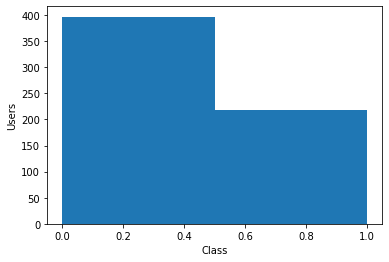

In [22]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(val_y))
plt.hist(val_y, bins=len(set(val_y)))
plt.ylabel('Users');
plt.xlabel('Class');

In [23]:
val_txt[:10]

['así debería ser siempre para que se mueran a la verga\n',
 'cada día me siento como un perro ovejero tratando de cuidar sus ovejas vale madre pinches rateros póngase a trabajar.😤\n',
 'hijo de tu puta madre nadamas te la pasas mamando pinche wilo de closet\n',
 'soñé horrible espero no se cumpla putos temblores.\n',
 '@usuario mejor vas y la chingas tú veo tus publicaciones y solo denotan inconformidad como típico ciudadano quejumbroso que no hace nada por cambiar\n',
 'y quizás este loca y quizás me guste estarlo... #siempreneruda\n',
 'me tienen hasta la verga con sus putos #boomerang pendejos y sin sentido.\n',
 'cuando va a ser el día que encuentre a alguien en quien pueda  confiar posts la re puta madre?\n',
 '#ahoritaestoypensando  como putas puede pasar esto?\n',
 '#todoibabienpero valio madre ya me atacó el insomnio🙅\n']

In [24]:
BOW_val=build_bow_tr(val_txt, V, dict_indices)

In [25]:
import math
from sklearn.model_selection import train_test_split

def compute_dor(TR, ndocs_out=0, y=None):    
    TR_subset_in = None
    if y is None:
        TR_subset_in, TR_subset_out = train_test_split(TR, test_size=ndocs_out, random_state=1)
    else :
        TR_subset_in, TR_subset_out = train_test_split(TR, stratify=y, test_size=ndocs_out, random_state=1)
    
    DTR = np.zeros((TR_subset_in.shape[1], TR_subset_in.shape[0]), dtype=np.float)
    print("DOR: Shape of the input matrix (BoT):", TR.shape)
    print("DOR: Shape of the term-feat matrix:", DTR.shape)

    tam_V = TR_subset_in.shape[1]
    for doc, i in zip(TR_subset_in, range(len(TR_subset_in))):
        nonzero_positions = np.nonzero(doc)[0] # returns a tuple of n-dimensions. Since we have 1D array docs, it returns a tuple with one element. thus, we get the 0 index.
        tam_v = len(nonzero_positions)
        for term in nonzero_positions:
            DTR[term, i] = (1 + math.log10(doc[term])) * math.log10(tam_V/tam_v)
    return DTR

In [31]:
from sklearn import preprocessing
DOR_base = compute_dor(BOW_tr, 0.01)
DOR_base = preprocessing.normalize(DOR_base, norm='l2')

DOR: Shape of the input matrix (BoT): (5544, 5000)
DOR: Shape of the term-feat matrix: (5000, 5488)


In [32]:
from sklearn.feature_selection import SelectKBest, chi2
feats = SelectKBest(chi2, k=1000)
feats.fit(BOW_tr, tr_y)

SelectKBest(k=1000, score_func=<function chi2 at 0x7fe938e8c710>)

In [33]:
best=feats.get_support(indices=True)

In [34]:
dict_indice_invertido = {}
for w in dict_indices:
    dict_indice_invertido[dict_indices[w]] = w

In [35]:
target_words = [dict_indice_invertido[index] for index in best]
words = [word for word in target_words if word in dict_indices] 
target_matrix = np.array([DOR_base[dict_indices[word]] for word in words])

In [36]:
target_matrix.shape

(1000, 5488)

In [39]:
from tsne import tsne
reduced_matrix = tsne(target_matrix, 2);

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.096264
Iteration 10: error is 17.503198
Iteration 20: error is 17.091254
Iteration 30: error is 16.861905
Iteration 40: error is 16.876680
Iteration 50: error is 16.867869
Iteration 60: error is 16.866986
Iteration 70: error is 16.875496
Iteration 80: error is 16.856598
Iteration 90: error is 16.863789
Iteration 100: error is 16.861329
Iteration 110: error is 1.991162
Iteration 120: error is 1.483604
Iteration 130: error is 1.287405
Iteration 140: error is 1.176682
Iteration 150: error is 1.106156
Iteration 160: error is 1.059750
Iteration 170: error is 1.027018
Iteration 180: error is 1.001503
Iteration 190: error is 0.980892
Iteration 200: error is 0.964195
Iteration 210: error is 0.950708
Iteration 220: error is 0.939616
Iteration 230: error is 0.930445
Iteration 240: error is 0.922697
Iteration 250: error is

In [40]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[1]

/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 129300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 129300 missing from current font.
  font.load_char(ord(s), flags=flags)
/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 129318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 129318 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/isaac/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:1

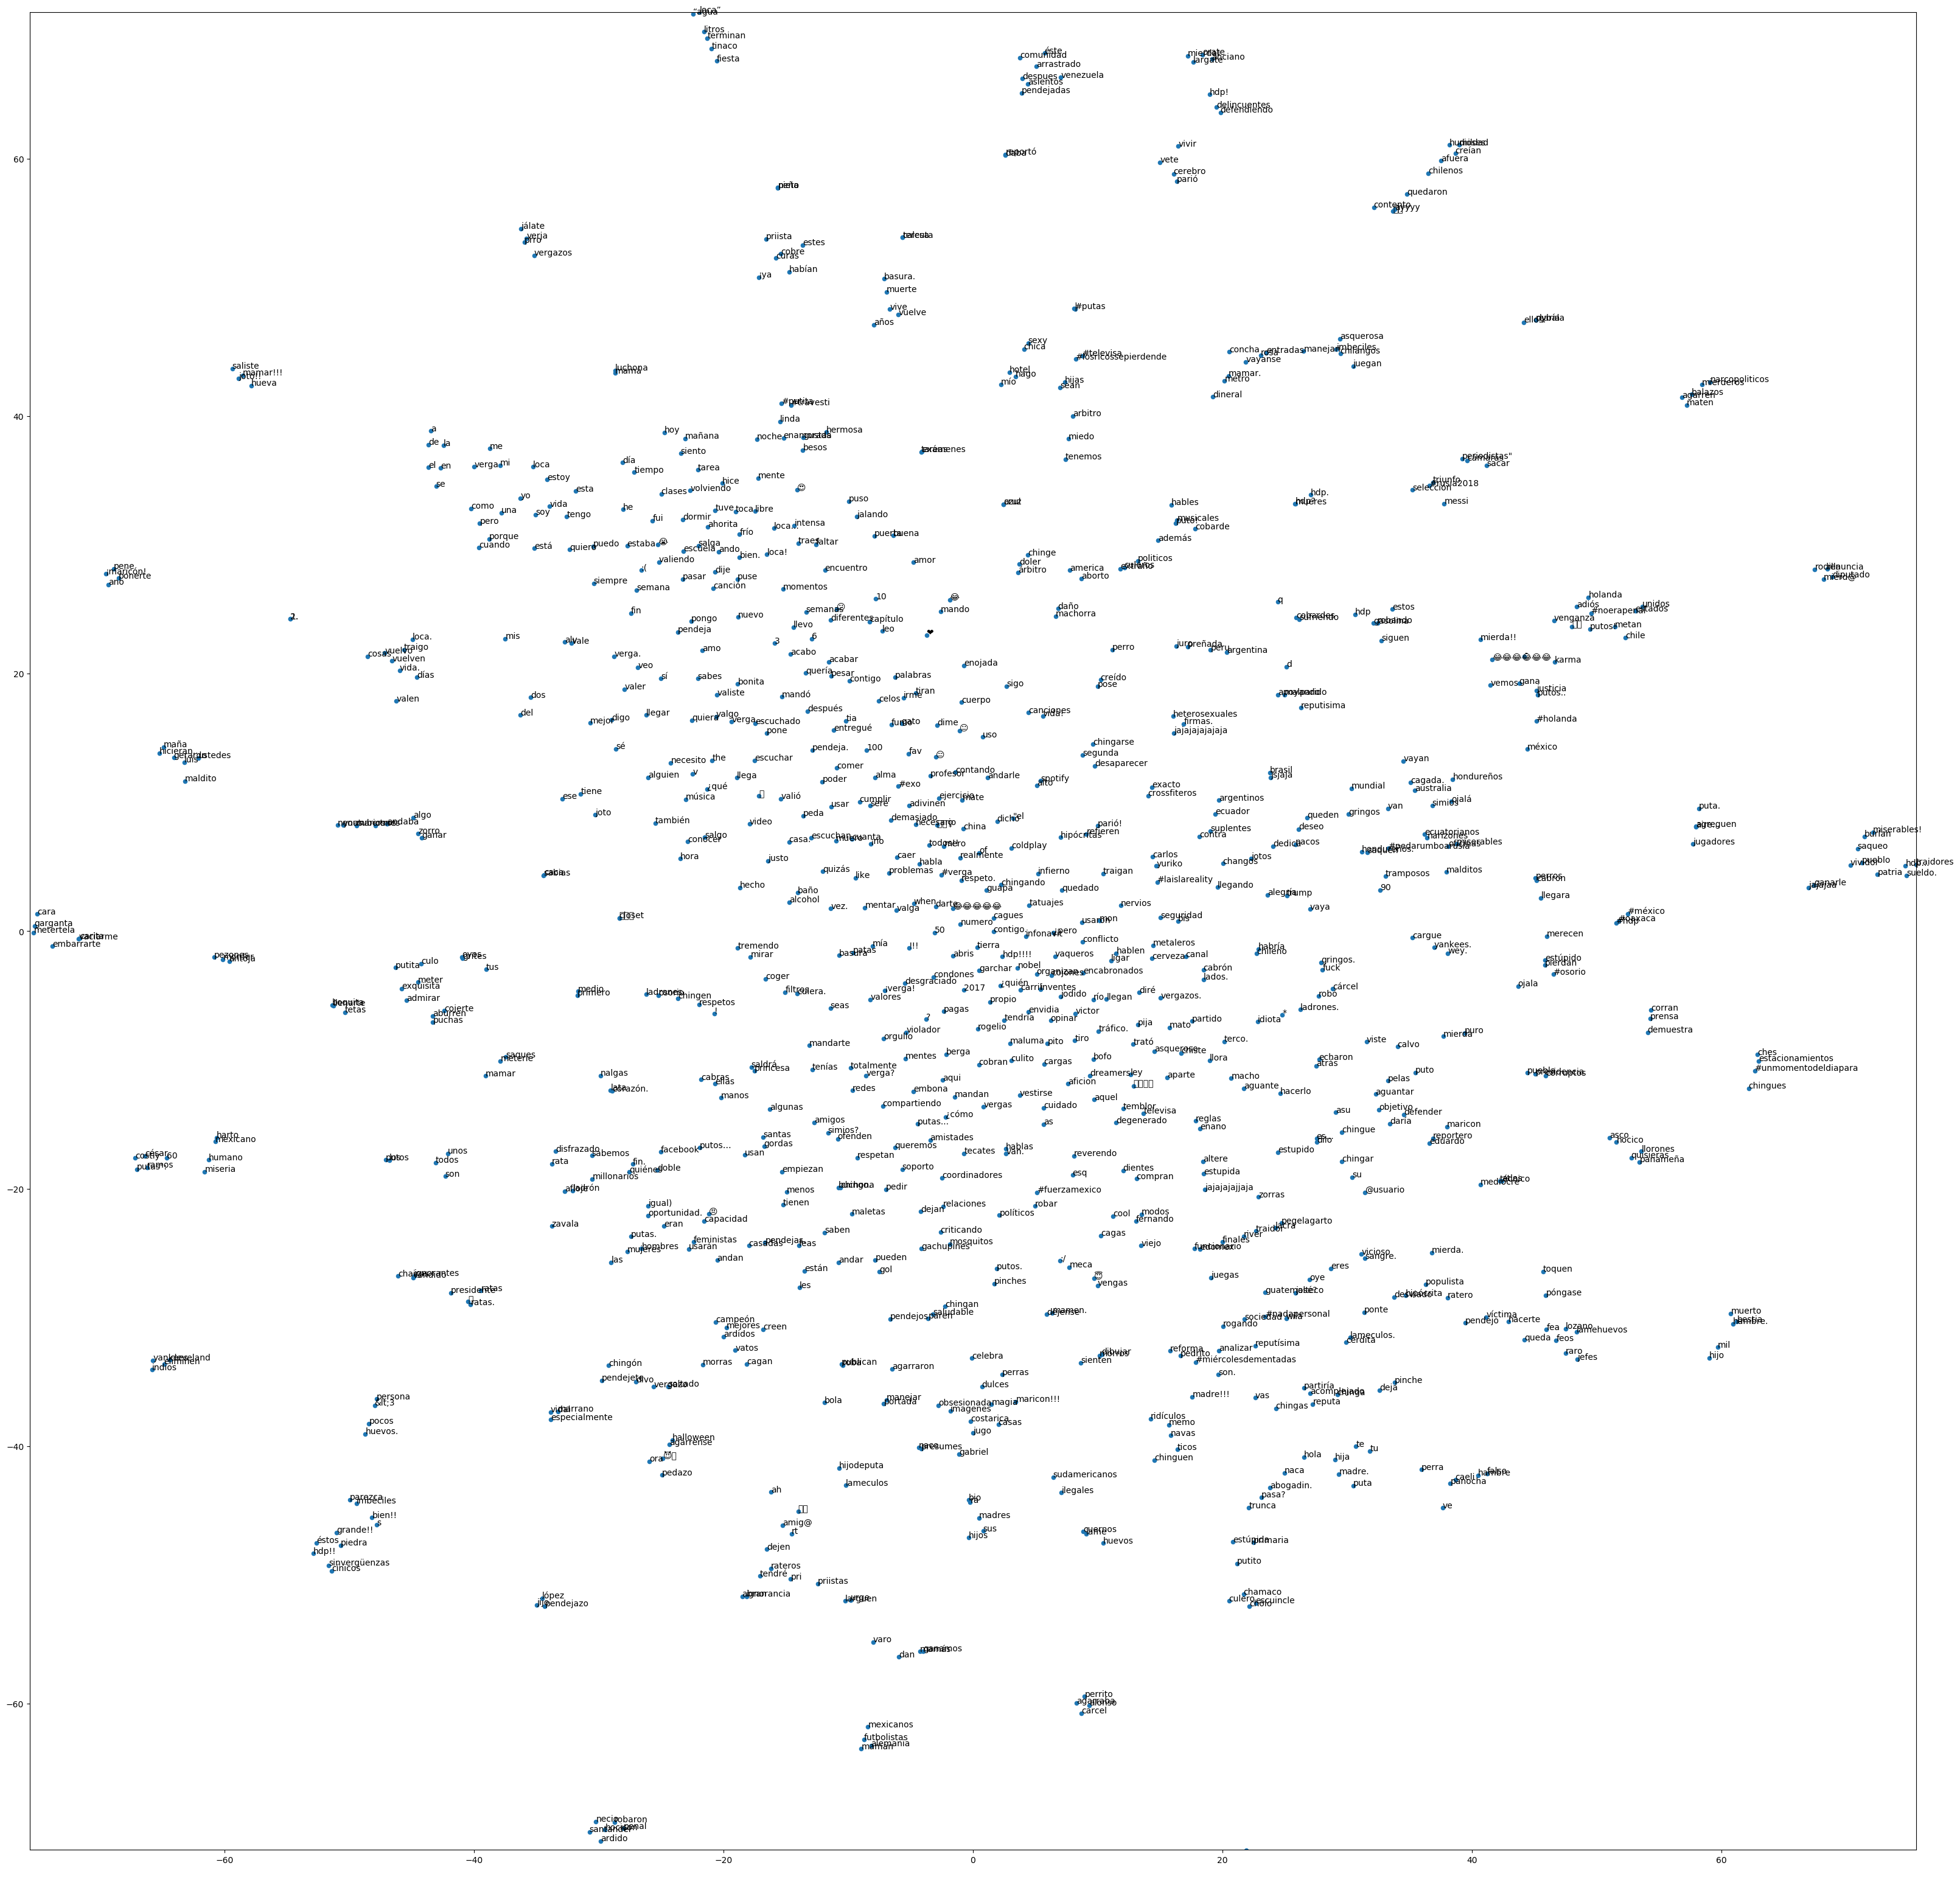

In [41]:
plt.figure(figsize=(40, 40), dpi=100); plt.xlim((-max_x,max_x)); plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20);
for idx, word in enumerate(words[:]):
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]
    plt.annotate(word, (x,y))